<a href="https://colab.research.google.com/github/lKAYNONl/MLlab/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing.image import ImageDataGenerator

# Скачать данные

In [ ]:
from sklearn.datasets import fetch_openml
data = fetch_openml('mnist_784', version=1, cache=True)

# загрузим датасет MNIST
# подробнее: https://ru.wikipedia.org/wiki/MNIST_(база_данных)

In [ ]:
X = data['data']
y = data['target']

In [ ]:
# количество изображений и размерность вектора, в который развёрнуто изображение 
data['data'].shape

(70000, 784)

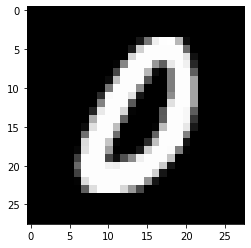

0



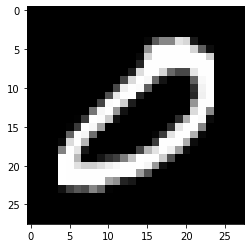

0



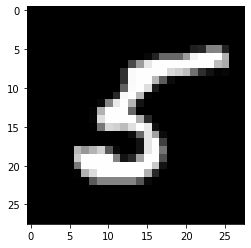

5



In [ ]:
for i in range(3):
  # номер изображения в датасете
  n = np.random.randint(0, X.shape[0] )
  # превратим вектор из 768 элементов в матрицу 28х28 и покажим как изображение
  plt.imshow( X[n].reshape(28, 28), cmap='gray' )
  plt.show()
  print( y[n] )
  print()

# Подготовка и предварительный анализ данных 

In [ ]:
# классы (они записаны в строках, переведём в числа)
y = y.astype(np.int8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=int8)

In [ ]:
# матрицы (ч\б. изображения)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

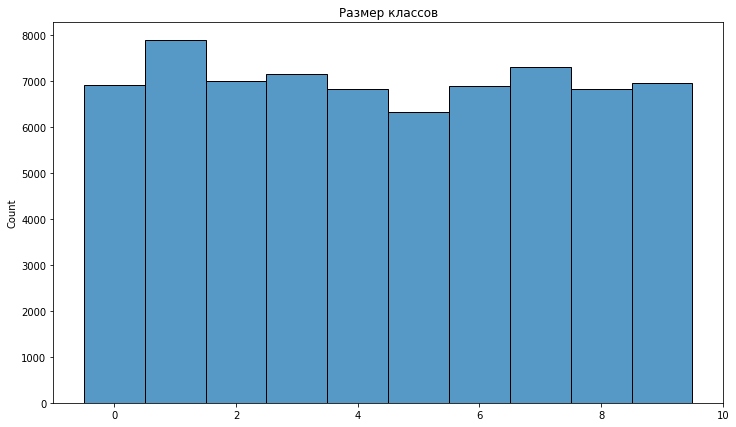

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Размер классов')
sb.histplot(y, discrete=True)

In [ ]:
from sklearn.model_selection import train_test_split

# часть оставим для финальной офенки модели
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state = 24, shuffle=True)

print(f"трейн X: {X_train.shape[0]:d}" )
print(f"трейн Y: {y_train.shape[0]:d}" )
print(f"тест X: {X_test.shape[0]:d}" )
print(f"тест Y: {y_test.shape[0]:d}" )

трейн X: 56000
трейн Y: 56000
тест X: 14000
тест Y: 14000


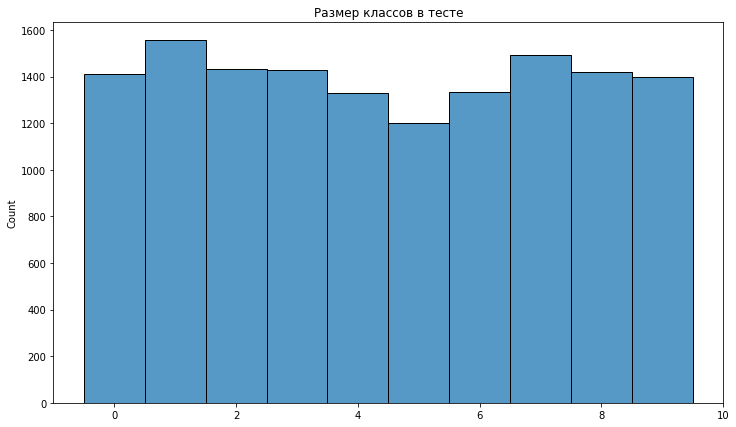

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Размер классов в тесте')
sb.histplot(y_test, discrete=True)

# Модели

## Случайный лес

Для сравнения с нейросетевыми методами

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(n_jobs=-1)


In [ ]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = forest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1412
           1       0.99      0.99      0.99      1555
           2       0.95      0.97      0.96      1432
           3       0.96      0.95      0.96      1426
           4       0.97      0.97      0.97      1329
           5       0.97      0.97      0.97      1199
           6       0.97      0.98      0.98      1334
           7       0.98      0.97      0.98      1493
           8       0.96      0.95      0.96      1420
           9       0.95      0.96      0.96      1400

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



## Keras CNN

In [ ]:
from keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from keras.layers.merge import concatenate
from keras import Input, Model, Sequential # Documentation: https://keras.io/models/sequential/
from keras import losses, optimizers

from keras.callbacks import Callback  # для прерывая обучения по условию
from keras import backend as K

from tqdm.keras import TqdmCallback   # для прогресбаров для обучения в keras
from sklearn.preprocessing import OneHotEncoder   # Keras хочет классы закодированные в one-hot

#### Подготовка данных для CNN на keras

In [ ]:
from sklearn.preprocessing import OneHotEncoder   # Keras хочет классы закодированные в one-hot
onehot_enc = OneHotEncoder()  # понадобится для Keras
onehot_enc.fit(  np.arange(10).reshape(-1,1) )  # reshape сделает столбец из строк единиченой длинны

# берём ранее загруженные данные 
X_train1 = (X_train-128)/255
# X_train[np.isnan(X_train)] = 0
# исходно картинка -- массив, нужно сделать из него матрицу
x_train_k = X_train1.reshape((X_train1.shape[0], 28, 28))
x_train_k = np.expand_dims( x_train_k, axis=3 )
y_train11 = onehot_enc.transform(y_train.reshape(-1,1))
y_train_k = y_train11.toarray()


X_test1 = (X_test-128)/255
# X_test[np.isnan(X_test)] = 0
x_test_k = X_test1.reshape((X_test1.shape[0], 28, 28))
x_test_k = np.expand_dims( x_test_k, axis=3 )
y_test11 = onehot_enc.transform(y_test.reshape(-1,1))
y_test_k = y_test11.toarray()

print(f"трейн X: {x_train_k.shape[0]:d}" )
print(f"трейн Y: {y_train_k.shape[0]:d}" )
print(f"тест X: {x_test_k.shape[0]:d}" )
print(f"тест Y: {y_test_k.shape[0]:d}" )

трейн X: 56000
трейн Y: 56000
тест X: 14000
тест Y: 14000


7


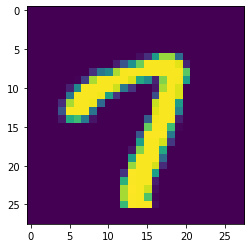

In [ ]:
print( np.argmax(y_train_k[5]) )
plt.imshow( x_train_k[5].reshape(28,28) )

 #### Построение модели

#### Актуальная модель

In [ ]:
#создание модели
model = Sequential()

#добавляем слой
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 padding = 'Same',activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 padding = 'Same',activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 padding = 'Same',activation ='relu', input_shape = (28,28,1)))
#MaxPooling2D — это способ уменьшить количество параметров в нашей модели, 
#переместив фильтр пула 2×2 по предыдущему слою и взяв максимум 4 значения в фильтре 2×2.
model.add(MaxPool2D(pool_size=(2,2)))  # 14
#метод регуляризации нашей модели с целью предотвращения переоснащения
model.add(Dropout(0.25))
# батчнорм только на этом слое приводит к резким паденями точности на валидации
# видимо средние и стандаратные отклонения на трейне заметно отличаются от аналогичных на валидации
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))                     # 14
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))                     # 12
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 activation ='relu'))                     # 10
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2))) # 5
model.add(Dropout(0.25))  


model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                   activation ='relu'))  # 3

# Создаем вектор для полносвязной сети.
# Flatten() – слой, преобразующий 2D-данные в 1D-данные.
model.add(Flatten())

# Создадим однослойный перцептрон
model.add(Dense(320, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

#Далее, нам нужно скомпилировать нашу модель.
# Компиляция модели использует три параметра: оптимизатор, потери и метрики.
model.compile(optimizer = optimizers.Adam(learning_rate=0.005), 
              loss=losses.categorical_crossentropy,
              metrics='accuracy')

model.build(input_shape=(28,28, 1))
#печатает краткое представление модели
model.summary()


# класс с коллбек функцией, которая останавливает обучение если достигната хорошая общая точность
class StopWhenAccuracy(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.9999:
      print("Stop!")
      self.model.stop_training= True

stop_condition =  StopWhenAccuracy()


# чтобы графики строить
AccTrain = []
AccVal = []
LossTrain = []
LossVal = []
TestAcc = []

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 128)       1

#### Аугментация

In [ ]:
# отделим валидационную выборку
x_train_k1, x_val_k1, y_train_k1, y_val_k1 = train_test_split(x_train_k, y_train_k, test_size=0.05, random_state=24)

train_im_gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_im_gen.fit(x_train_k1, seed=24)



4


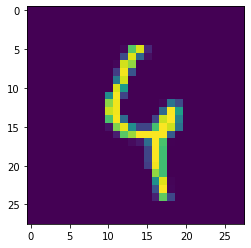

In [ ]:
i = int(np.random.uniform(0, 1000))
print(np.argmax(y_val_k1[i]))
plt.imshow(x_val_k1[i].reshape(28,28))

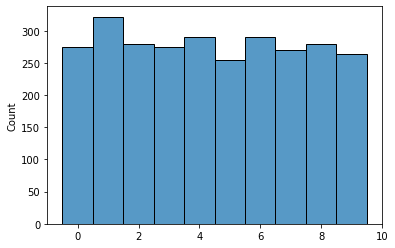

In [ ]:
sb.histplot( np.argmax(y_val_k1, axis=1), discrete=True)

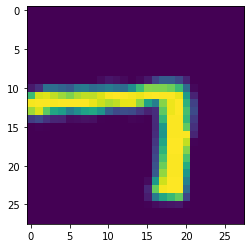

In [ ]:
plt.imshow( train_im_gen.flow(x_train_k1, y_train_k1, batch_size=1).next()[0].reshape(28,28) )
plt.show()

### Обучение

In [ ]:
import tensorflow as tf

# при необходимости можно повторить обучение с другим lr
# K.set_value(model.optimizer.learning_rate, 0.0001)
K.set_value(model.optimizer.learning_rate, 0.0001)

with tf.device('/device:GPU:0'):
  History = model.fit( train_im_gen.flow(x_train_k1, y_train_k1, batch_size=7000),
                      validation_data = (x_val_k1, y_val_k1),
                      callbacks = [stop_condition, TqdmCallback(verbose=2)],  # вместо общего verbose TqdmCallback(verbose=2) который будет показывать прогресс по батчам  
                      epochs=10) 

  # History = model.fit( x_train_k, y_train_k, batch_size=7000,
  #                   validation_split=0.05,
  #                   callbacks = [stop_condition, TqdmCallback(verbose=2)],  # вместо общего verbose TqdmCallback(verbose=2) который будет показывать прогресс по батчам  
  #                   epochs=10) 

AccTrain += History.history['accuracy']
AccVal +=   History.history['val_accuracy']
LossTrain += History.history['loss']
LossVal +=   History.history['val_loss']

Epoch 1/10


8/8 [==============================] - 80s 3s/step - loss: 2.3005 - accuracy: 0.1275 - val_loss: 2.2811 - val_accuracy: 0.2979
Epoch 2/10



8/8 [==============================] - 14s 2s/step - loss: 2.2801 - accuracy: 0.2006 - val_loss: 2.1692 - val_accuracy: 0.4879
Epoch 3/10



8/8 [==============================] - 15s 2s/step - loss: 2.1769 - accuracy: 0.2994 - val_loss: 1.7029 - val_accuracy: 0.6493
Epoch 4/10



8/8 [==============================] - 15s 2s/step - loss: 1.8420 - accuracy: 0.3944 - val_loss: 0.9983 - val_accuracy: 0.7175
Epoch 5/10



8/8 [==============================] - 15s 2s/step - loss: 1.4910 - accuracy: 0.4810 - val_loss: 0.7762 - val_accuracy: 0.7932
Epoch 6/10



8/8 [==============================] - 15s 2s/step - loss: 1.2776 - accuracy: 0.5614 - val_loss: 0.5811 - val_accuracy: 0.8289
Epoch 7/10



8/8 [==============================] - 15s 2s/step - loss: 1.1055 - accuracy: 0.6260 - val_loss: 0.4717 - val_accuracy: 0.8514
Epoch 8/10



8/8 [==============================] - 15s 2s/step - loss: 0.9208 - accuracy: 0.6969 - val_loss: 0.3278 - val_accuracy: 0.9064
Epoch 9/10



8/8 [==============================] - 15s 2s/step - loss: 0.7652 - accuracy: 0.7472 - val_loss: 0.2763 - val_accuracy: 0.9168
Epoch 10/10



8/8 [==============================] - 15s 2s/step - loss: 0.6524 - accuracy: 0.7877 - val_loss: 0.2447 - val_accuracy: 0.9254




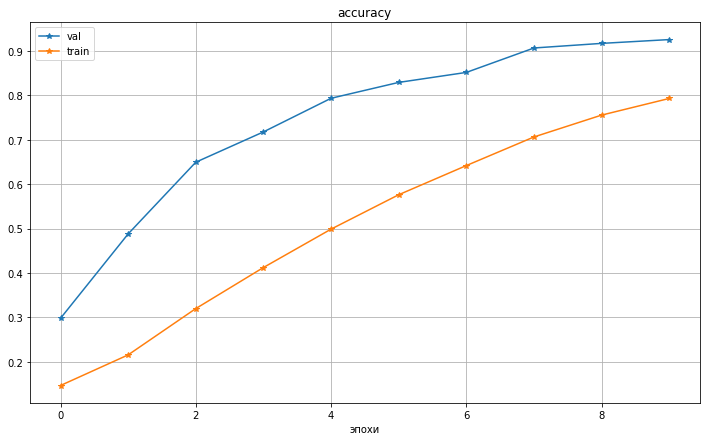

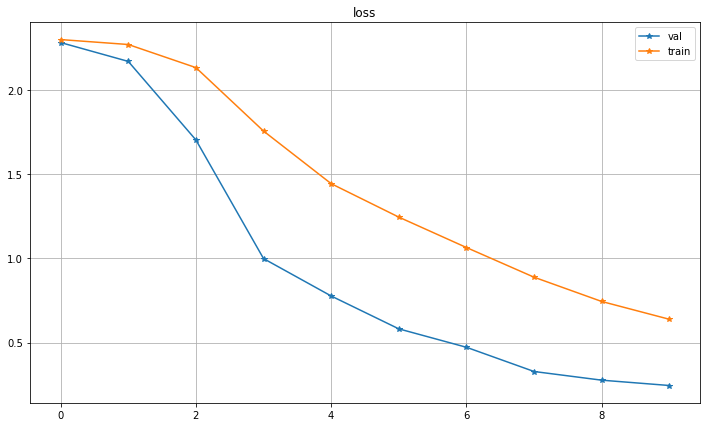

In [ ]:
# построим кривые обучения
plt.figure( figsize=(12,7) )
plt.title('accuracy')
plt.plot( AccVal, '*-', label='val')
plt.plot( AccTrain,     '*-', label='train')
plt.xlabel('эпохи')
plt.legend(loc=0)
plt.grid()
plt.show()


plt.figure( figsize=(12,7) )
plt.title('loss')
plt.plot( LossVal, '*-', label='val')
plt.plot( LossTrain,     '*-', label='train')
plt.legend(loc=0)
plt.grid()
plt.show()

### Финальная оценка на тесте

In [ ]:
y_pred = model.predict( x_test_k )
y_pred = onehot_enc.inverse_transform(y_pred)

print( classification_report(y_test, y_pred, digits=4) )

TestAcc += [ accuracy_score(y_test, y_pred)]
print( TestAcc[-1] )

print( TestAcc )

              precision    recall  f1-score   support

           0     0.9556    0.9610    0.9583      1412
           1     0.9863    0.9723    0.9793      1555
           2     0.9350    0.9246    0.9298      1432
           3     0.8688    0.9565    0.9105      1426
           4     0.9804    0.8668    0.9201      1329
           5     0.9543    0.9058    0.9294      1199
           6     0.9108    0.9565    0.9331      1334
           7     0.9727    0.8607    0.9133      1493
           8     0.8748    0.9296    0.9013      1420
           9     0.8543    0.9257    0.8886      1400

    accuracy                         0.9266     14000
   macro avg     0.9293    0.9260    0.9264     14000
weighted avg     0.9295    0.9266    0.9268     14000

0.9265714285714286
[0.9265714285714286]


###Выводы

По результатам сверточной сети, можно понять:
*   что 1 распознается правильно больше остальных цифр, с точностью 0.9793
*   а 9 распознается правильно меньше остальных, с точностью 0.8886
